In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
import math

from scipy.odr import ODR, Model, Data, RealData
import scipy.ndimage
import random

import functions_timescale as funcs

## Input

In [2]:
## input for the random sampling
min_intensity = 100. ## based on the PDR Toolbox, imposes a minimal FUV field of G0~10^3
sampleSize = 10000
corrFactSize = 2. ## Correction factor based on physical size test with random sampling of a ring

## input for the radial cuts through the observational maps
dtheta = 15. ## in degrees
numCuts = int(180./dtheta + 0.5)
margin_for_cut = 3.
save_cuts_maps = False
save_cuts_profiles = False

## Input to extract the M42 region of interest from the Orion A map
x1_M42 = 260
x2_M42 = 260+720
y1_M42 = 20
y2_M42 = 20+640

In [3]:
## make dictionary with distance (distance in parsec) and age (min, estimate, max) (in Myr) and velocities that define the 
## NOTE: work with the FWHM/2 for the analysis which explains the 0.5*2.35 in [-2] and [-3]
## NOTE: M42 has no 0.5*, because only fits blue wings (see spectrum), so take full FWHM ##
names = {
    'm16_CII_final_20_8_0p5_clean': [1706.,0.2,1.3,0.2,5.,11.,33.,41.,0.5*2.35*7.0,0.5*2.35*0.008,'M16'],
    'm17_CII_final_20_8_0p5_clean': [1900.,0.15,0.58,0.15,-11.,8.,36.,52.,0.5*2.35*10.6,0.5*2.35*0.05,'M17'],
    'RCW120_CII_final_20_8_0p5_clean': [1680.,1.2,1.2,1.8,-30.,-14.,-2.,18.,0.5*2.35*5.3,0.5*2.35*0.2,'RCW 120'],
    'RCW79_CII_final_20_8_0p5_clean': [3900.,0.5,2.3,0.5,-70.,-54.,-40.,-26.,0.5*2.35*7.9,0.5*2.35*0.1,'RCW 79'],
    'RCW36_CII_final_20_8_0p5_clean': [950.,0.6,1.1,0.6,-12.,-1.,13.,22.,0.5*2.35*6.0,0.5*2.35*0.08,'RCW 36'],
    'W40_CII_final_20_8_0p5_clean': [502.,0.9,0.9,0.9,-14.,1.,13.,23.,0.5*2.35*8.1,0.5*2.35*0.08,'W40'],
    'NGC7538_CII_final_20_8_0p5_clean': [2650.,0.85,2.2,0.85,-80.,-64.,-47.,-33.,0.5*2.35*8.5,0.5*2.35*0.2,'NGC 7538'],
    'RCW49_CII_final_20_8_0p5_clean': [4160.,0.75,1.25,0.75,-31.,-14.,23.,39.,0.5*2.35*11.4,0.5*2.35*0.5,'RCW 49'],
    'OrionA_CII_final_20_8_0p5_clean': [414.,0.5,2.5,0.5,-12.,4.,14.,25.,2.35*5.4,2.35*0.03,'M42'], 
}

## References for the cluster age and distances

- age M16: Stoop+2023
- age M17: Hanson+1997 (look for better)
- age RCW120: Martins+2010
- age RCW79: Martins+2010
- age RCW 36: Ellerbroeck+2013
- age W40: 0.9 Myr+-0.9 Comeron+2022 (distance: 502 pc)
- NGC 7538: Puga+2010: age spread (0.5-2.2 Myr, median: 1.35): Based on maximum age of 60 solar mass star and PMS stars
- RCW 49: age: Zeidler (age range: 0.5-2.0 Myr, middle: 1.25), distance: Cantat-Gaudin
- M42: distance: Menten+2007, age: 2-3 Myr (Da Rio et al. 2010)

## Loop over the regions to estimate their dynamical timescale

Filename: ../allRegions/final/m16_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (295, 283)   float32   
Filename: ../allRegions/m16_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (295, 283, 200)   float32   


[22.166070196030642, 21.769065953713675, 25.209769387127388, 24.151091407615475, 24.878932518529915, 26.46694948779778, 9.726603936765684, 8.006252220058828, 11.645457774631023, 9.925106057924168, 14.42448747084979, 17.79902353054401]


<Figure size 432x288 with 0 Axes>

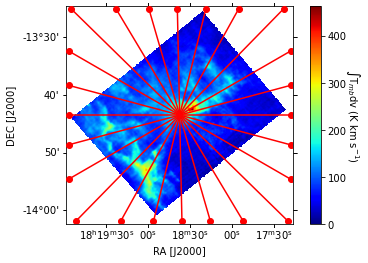

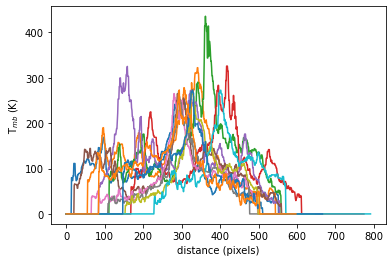

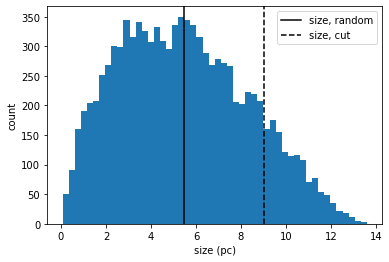

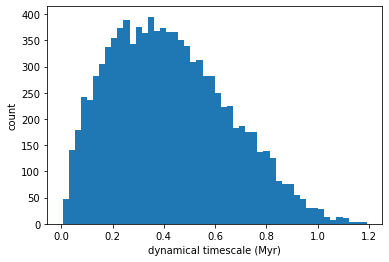

Filename: ../allRegions/final/m17_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (191, 191)   float32   
Filename: ../allRegions/m17_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (191, 191, 200)   float32   


[23.360263300850825, 17.538620396222388, 24.981480312266342, 30.2872814405353, 25.12886367694048, 21.07582114840169, 21.88642965410945, 21.223204513075828, 17.9807704902448, 16.506936843503425, 21.14951283073876, 24.244563488895654]


<Figure size 432x288 with 0 Axes>

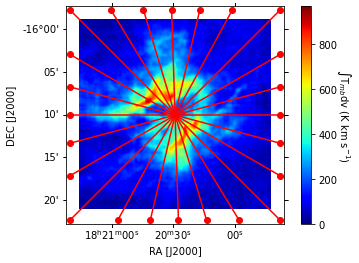

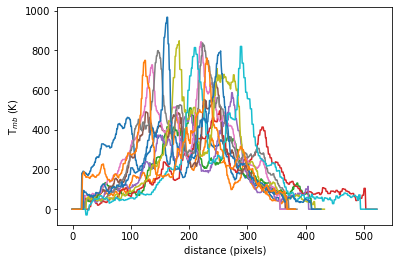

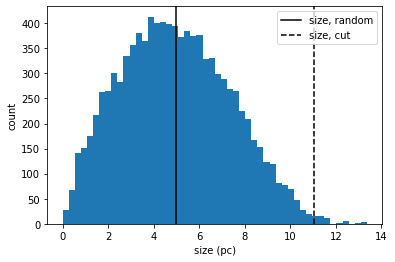

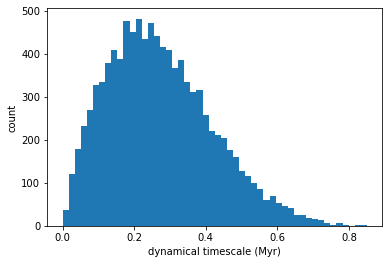

Filename: ../allRegions/final/RCW120_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (136, 137)   float32   
Filename: ../allRegions/RCW120_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (136, 137, 320)   float32   


Not possible to estimate size along this axis
[7.362962618352185, 7.362962618352185, 8.535823920390586, 8.731300804063652, 8.796459765288008, 8.666141842839297]


<Figure size 432x288 with 0 Axes>

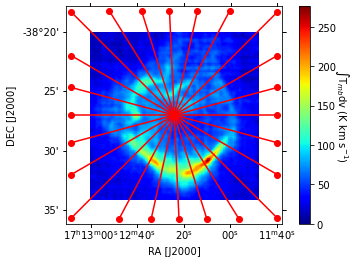

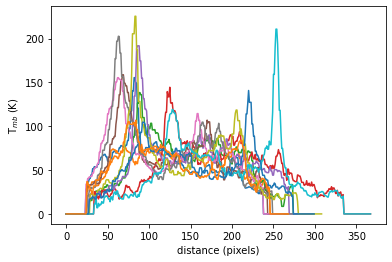

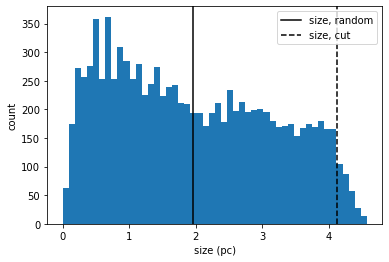

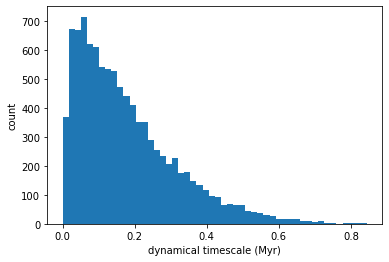

Filename: ../allRegions/final/RCW79_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (188, 188)   float32   
Filename: ../allRegions/RCW79_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   


[25.260733003227863, 24.201899883332082, 22.99180488916548, 22.538019266353004, 25.41199487749869, 18.151424912499063, 25.109471128957036]


<Figure size 432x288 with 0 Axes>

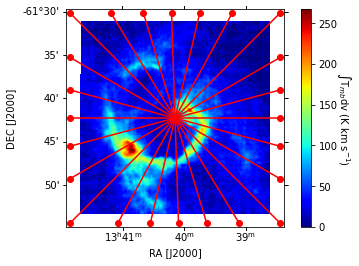

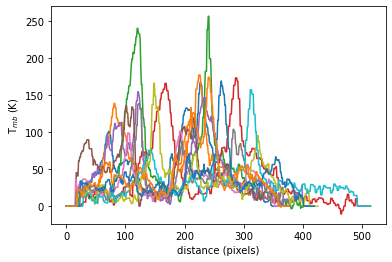

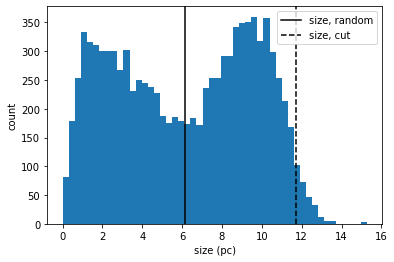

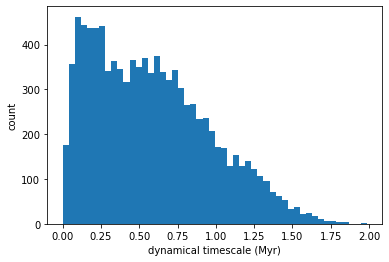

Filename: ../allRegions/final/RCW36_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (108, 55)   float32   
Filename: ../allRegions/RCW36_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 55, 901)   float32   


[2.616054722965944, 1.6580628525840493, 1.8054462172581869, 1.8422920584267213, 1.9528295819323247, 2.2107504701120657, 2.5792088817974097, 2.7265922464715477, 2.9108214523142197]


<Figure size 432x288 with 0 Axes>

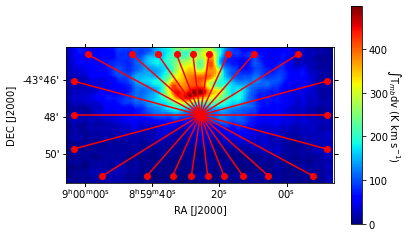

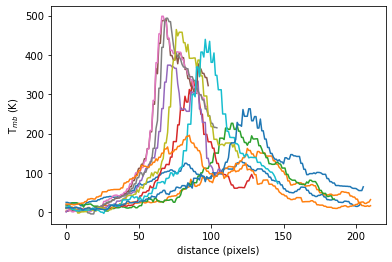

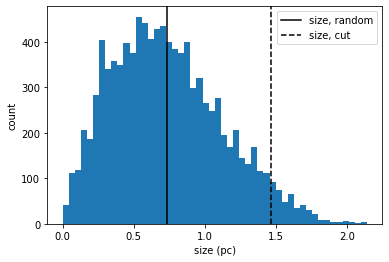

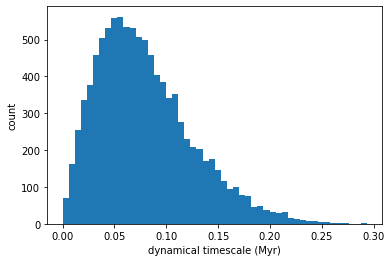

Filename: ../allRegions/final/W40_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (231, 233)   float32   
Filename: ../allRegions/W40_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (231, 233, 400)   float32   


[3.0178683171828036, 4.166605289529806, 4.614418007563383, 4.147135171354433, 4.283425998582044, 5.179051434649199, 3.173629262585787, 4.439186943985027, 3.3293902079887703, 3.0568085535335494, 2.901047608130566, 3.0373384353581763]


<Figure size 432x288 with 0 Axes>

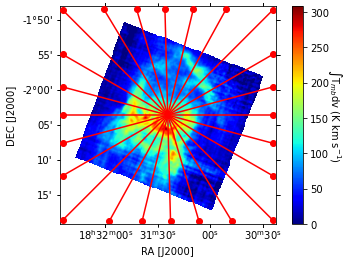

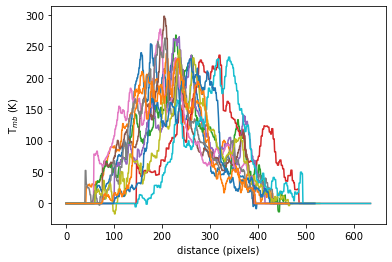

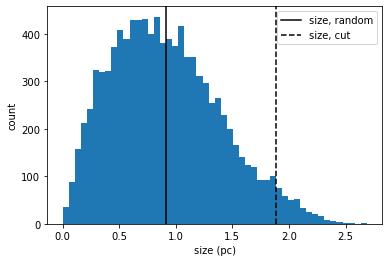

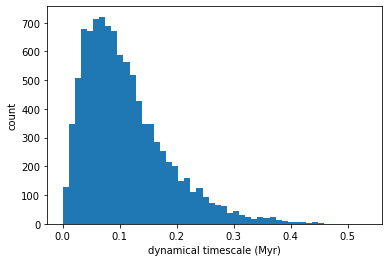

Filename: ../allRegions/final/NGC7538_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (108, 104)   float32   
Filename: ../allRegions/NGC7538_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 104, 901)   float32   


[9.969708918286079, 8.325220849290437, 9.558586901037168, 5.550147232860291, 5.241805719923608, 9.764147909661624, 9.353025892412713, 8.736342866539347, 9.86692841397385, 10.586391944159445, 11.100294465720582, 12.230880013155087]


<Figure size 432x288 with 0 Axes>

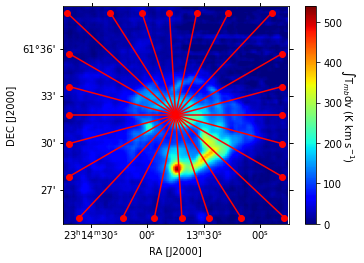

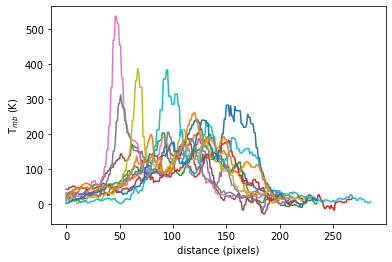

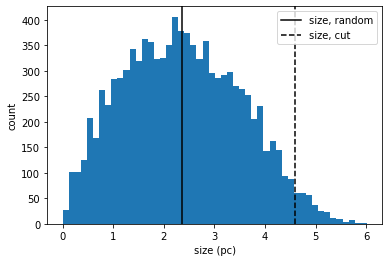

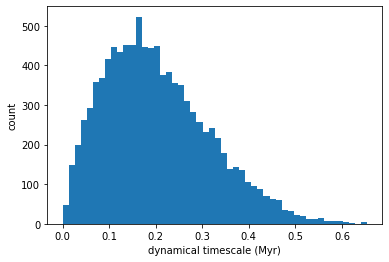

Filename: ../allRegions/final/RCW49_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (177, 254)   float32   
Filename: ../allRegions/RCW49_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (177, 254, 400)   float32   


[16.618637919888034, 25.492667877109795, 25.492667877109795, 23.55651588644323, 41.30457580088676, 38.72303981333134, 40.82053780322012, 38.56169381410912, 29.20362585922072, 31.46246984833171, 28.07420386466522, 21.45901789655445]


<Figure size 432x288 with 0 Axes>

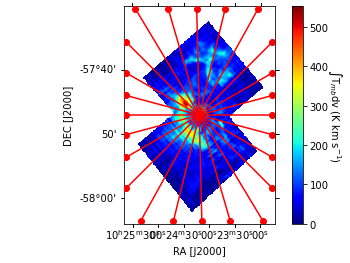

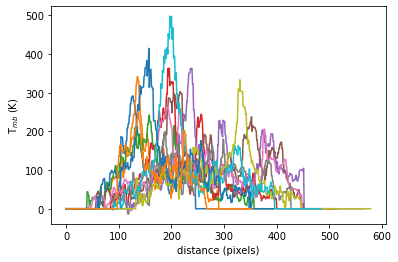

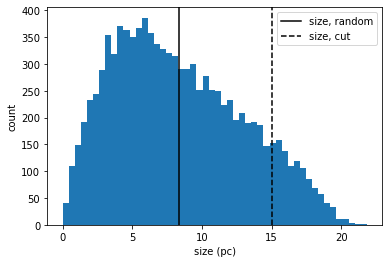

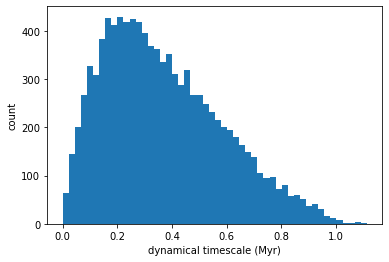

Filename: ../allRegions/final/OrionA_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1151, 1520)   float32   
Filename: ../allRegions/OrionA_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (1151, 1520, 519)   float32   


[5.278045726823414, 9.381620152503816, 7.761415767192071, 6.969001395336545, 6.643545492610168, 6.261488563322683, 4.457330841687334, 2.5258208102894892, 2.278191319084637]


<Figure size 432x288 with 0 Axes>

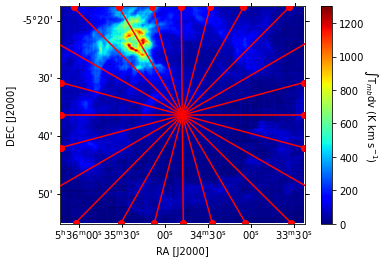

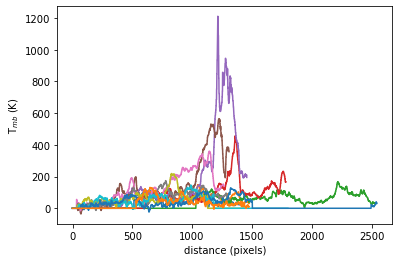

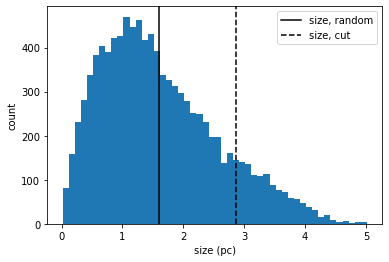

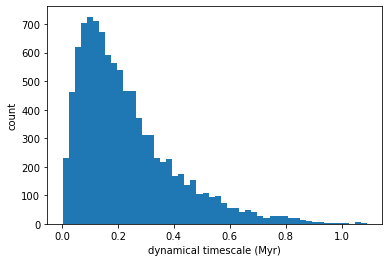

<Figure size 432x288 with 0 Axes>

In [4]:
## Create the arrays to store the results and the uncertainty estimates
avSizeList = []
avSizeErrList = []
altSizeList = []
altSizeErrList = []

clusterAgeList = []
clusterAgeListMin = []
clusterAgeListMax = []

dynAgeList_MC = []
dynAgeErrListMin_MC = []
dynAgeErrListMax_MC = []

altDynAgeListFWHM = []
altDynAgeErrListFWHMMin = []
altDynAgeErrListFWHMMax = []

vExpList = []
vExpErrListMax = []
vExpErrListMin = []
vExpListFWHM = []
vExpErrListFWHMMax = []
vExpErrListFWHMMin = []

regionNames = []

## Loop over the regions in the dictionary to calculate the size for each region
for name in names:
    ## open the integrated intenstiy fits file and store the WCS information
    hdu = pyfits.open('../allRegions/final/'+name+'_integrated.fits')
    hdu.info()
    data = hdu[0].data
    header = hdu[0].header
    w = wcs.WCS(header)
    
    ## calculate the physical pixel size of the map
    pixSize = names[name][0]*header['CDELT2']*np.pi/180.
    
    ## open the spectral data cube of the same region and store information on the spectral cube
    try:
        hdu = pyfits.open('../allRegions/'+name+'.fits')
    except FileNotFoundError as ferr:
        hdu = pyfits.open('../allRegions/non-FEEDBACK/'+name+'.fits')
    hdu.info()
    cube = hdu[0].data
    headerCube = hdu[0].header
    crval = 0.001*headerCube['CRVAL3']
    cdelt = 0.001*headerCube['CDELT3']
    crpix = headerCube['CRPIX3']
    
    ## store the name for plotting
    regionNames.append(names[name][10])
    
    ## Remove all the unnecessary data from a map
    if(name=='OrionA_CII_final_20_8_0p5_clean'):
        data = funcs.extract_region_in_map(data,x1_M42,x2_M42,y1_M42,y2_M42)
        cube = funcs.extract_region_in_cube(cube,x1_M42,x2_M42,y1_M42,y2_M42,0,len(cube))
    
    ## Make a copy of the data
    datac = data.copy()
    
    ## Extract the regions with an intensity above the specified minum_intensity to determine the size of the region
    data[data<min_intensity] = np.nan
    indices = np.argwhere(~np.isnan(data))
    
    
    #### APPROACH 1: RANDOM SAMPLING TO GET VELOCITY AND PHYSICAL SIZE ####
    ## create the average spectrum and velocity array for the region (2 arrays)
    spec = np.nanmean(cube,axis=(1,2))
    velArr = np.array([crval + 0.5*cdelt + cdelt*(i-crpix) for i in range(0,len(cube))])
    
    ## Combine the spectrum and velocity axes of the blue and redshifted wings (4 arrays) for random sampling
    velArrB, specB = funcs.get_velArr_and_spec_in_interval(names[name][4],names[name][5],crval,cdelt,crpix,velArr,spec)
    velArrR, specR = funcs.get_velArr_and_spec_in_interval(names[name][6],names[name][7],crval,cdelt,crpix,velArr,spec)
    velArrW = np.append(velArrB,velArrR)
    specW = np.append(specB,specR)
    
    ## Randomly sample the "mass-ejection" velocity based on the spectral profile of the combined blue and red-wings
    cdf = np.cumsum(specW)
    cdf = cdf/cdf[-1]
    values = np.random.rand(sampleSize)
    vel_inds = np.searchsorted(cdf,values)
    velArrW_random = velArrW[vel_inds]
    
    ## Estimate a mass-ejection/expansion velocity relative to the bulk motion from the definition of the wings
    vB = 0.5*(names[name][4] + names[name][5])
    vR = 0.5*(names[name][6] + names[name][7])
    vCent = 0.5*(vB + vR)
    vel_exp_random = np.abs(velArrW_random - vCent)
    vExp = np.nanmean(vel_exp_random)
    vExpList.append(vExp)
    
    ## Estimate the standard deviation on the expansion velocity
    vExpErr = np.nanstd(vel_exp_random)
    vExpErrListMax.append(vExpErr)
    vExpErrListMin.append(vExpErr)
    
    ## Create a randomly sampled list of radii associated with the 2D map (explains dimension = 2 for the function)
    rList = funcs.sample_radius_size_from_indices(indices,sampleSize,2,pixSize,corrFactSize)
    avSize = np.nanmean(rList)
    avSizeErr = np.nanstd(rList)
    
    
    #### APPROACH 2: CUTS THROUGH THE MAP TO GET VELOCITY AND PHYSICAL SIZE ####
    ## Get size from cuts over the map
    altSize = 0.
    attSizeErr = 0.
    if(name=='OrionA_CII_final_20_8_0p5_clean'):
        altSize, altSizeErr = funcs.avSizeFromCuts(x1_M42,x2_M42,y1_M42,y2_M42,dtheta,numCuts,margin_for_cut,min_intensity,datac,w,pixSize,name,save_cuts_maps,save_cuts_profiles)
    else:
        altSize, altSizeErr = funcs.avSizeFromCuts(0,len(data[0]),0,len(data),dtheta,numCuts,margin_for_cut,min_intensity,datac,w,pixSize,name,save_cuts_maps,save_cuts_profiles)
    ## Correction for RCW 36 because only half of the map was observed
    if(name == 'RCW36_CII_final_20_8_0p5_clean'):
        altSize = 2.*avSize
        altSizeErr = 2.*avSizeErr
    altSizeList.append(altSize)
    altSizeErrList.append(altSizeErr)
    
    ## add exceptions to get the average size (e.g. incomplete map)
    if(names[name] == 'RCW36_CII_final_20_8_0p5_clean'):
        avSize = 2.*avSize
        avSizeErr = 2.*avSizeErr
    
    avSizeList.append(avSize)
    avSizeErrList.append(avSizeErr)
    
    
    ## Calculate the expansion velocity based on the wings
    vExpFWHM = names[name][8]
    vExpListFWHM.append(vExpFWHM)
    
    ## Calculate the expansion velocity error based on the wings
    vExpErrFWHM = names[name][9]
    vExpErrListFWHMMin.append(vExpErrFWHM)
    vExpErrListFWHMMax.append(vExpErrFWHM)
    
    
    #### CALCULATE THE EXPANSION TIMESCALES #### 
    ## calculate dynamical timescales from MC work (note that the distributions are clearly not always Gaussian)
    dyn_ages_MC = np.array(rList/vel_exp_random)
    dyn_age_MC = np.nanmean(dyn_ages_MC)
    dyn_age_MC_err = np.nanstd(dyn_ages_MC)
    if(names[name] == 'RCW36_CII_final_20_8_0p5_clean'):
        dyn_age_MC = 2.*dyn_age_MC
        dyn_age_MC_err = 2.*dyn_age_MC_err
    dynAgeList_MC.append(dyn_age_MC)
    dynAgeErrListMin_MC.append(dyn_age_MC_err)
    dynAgeErrListMax_MC.append(dyn_age_MC_err)
    
    ## calculate the dynamics timescale from the cuts and FWHM 
    altDynAgeFWHM = altSize/vExpFWHM
    altDynAgeListFWHM.append(altDynAgeFWHM)
    altDynAgeErrFWHM = altDynAgeFWHM*np.sqrt((vExpErrFWHM/vExpFWHM)**2 + (altSizeErr/altSize)**2)
    altDynAgeErrListFWHMMin.append(altDynAgeErrFWHM)
    altDynAgeErrListFWHMMax.append(altDynAgeErrFWHM)
    
    
    ## add the cluster age
    clusterAgeList.append(names[name][2])
    clusterAgeListMin.append(names[name][1])
    clusterAgeListMax.append(names[name][3])
    
    ## plot the histogram
    plt.hist(rList,bins=50)
    plt.axvline(x=avSize,color='k',label='size, random')
    plt.axvline(x=altSize,color='k',linestyle='--',label='size, cut')
    plt.xlabel('size (pc)')
    plt.ylabel('count')
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.hist(dyn_ages_MC,bins=50)
    plt.xlabel('dynamical timescale (Myr)')
    plt.ylabel('count')
    plt.show()
    plt.clf()
    
    #dataRav = data.ravel()
    #dataRav = dataRav[~np.isnan(dataRav)]
    #print(len(dataRav))

In [5]:
## calculate the age difference and propagate the error
ageDiffList = []
ageDiffListMin = []
ageDiffListMax = []

altAgeDiffListFWHM = []
altAgeDiffListFWHMMin = []
altAgeDiffListFWHMMax = []

for d1, dFWHMa, a1, d1Min, d1Max, dFWHMaMin, dFWHMaMax, a1Min, a1Max in zip(dynAgeList_MC,altDynAgeListFWHM,clusterAgeList,dynAgeErrListMin_MC,dynAgeErrListMax_MC,altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax,clusterAgeListMin,clusterAgeListMax):
    ageDiffList.append(a1-d1)
    ageDiffListMin.append(np.sqrt(a1Min**2 + d1Min**2))
    ageDiffListMax.append(np.sqrt(a1Max**2 + d1Max**2))
    
    altAgeDiffListFWHM.append(a1-dFWHMa)
    altAgeDiffListFWHMMin.append(np.sqrt(a1Min**2 + dFWHMaMin**2))
    altAgeDiffListFWHMMax.append(np.sqrt(a1Max**2 + dFWHMaMax**2))

## Fitting to the cluster and dynamical timescale results

In [6]:
## fit linear function to data
data1 = RealData(clusterAgeList,ageDiffList,sx=clusterAgeListMin,sy=ageDiffListMin)
linear = Model(funcs.linFunc)
odr1 = ODR(data1,linear,beta0=[1.,0.5])
output1 = odr1.run()
output1.pprint()
x1 = np.linspace(0.,3.,10)
y1 = funcs.linFunc(output1.beta, x1)

linear_no = Model(funcs.linFunc_noOff)
odr1_no = ODR(data1,linear_no,beta0=[1.])
output1_no = odr1_no.run()
output1_no.pprint()
x1_no = np.linspace(0.,3.,10)
y1_no = funcs.linFunc_noOff(output1_no.beta, x1_no)

Beta: [ 0.94916323 -0.25721358]
Beta Std Error: [0.06341    0.07831806]
Beta Covariance: [[ 0.08525709 -0.09136028]
 [-0.09136028  0.13005851]]
Residual Variance: 0.047161219310824606
Inverse Condition #: 0.2505924869658569
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.7741129]
Beta Std Error: [0.04549918]
Beta Covariance: [[0.01829217]]
Residual Variance: 0.11317276024158968
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Sum of squares convergence


In [7]:
dataFWHMa = RealData(clusterAgeList,altAgeDiffListFWHM,sx=clusterAgeListMin,sy=altAgeDiffListFWHMMin)
linear = Model(funcs.linFunc)
odrFWHM = ODR(dataFWHMa,linear,beta0=[1.,0.5])
outputFWHMa = odrFWHM.run()
outputFWHMa.pprint()
xFWHMa = np.linspace(0.,3.,10)
yFWHMa = funcs.linFunc(outputFWHMa.beta, xFWHMa)

linear_no = Model(funcs.linFunc_noOff)
odrFWHM_no = ODR(dataFWHMa,linear_no,beta0=[1.])
outputFWHMa_no = odrFWHM_no.run()
outputFWHMa_no.pprint()
xFWHMa_no = np.linspace(0.,3.,10)
yFWHMa_no = funcs.linFunc_noOff(outputFWHMa_no.beta, xFWHMa_no)

Beta: [ 1.17467411 -1.03011915]
Beta Std Error: [0.17107207 0.21264211]
Beta Covariance: [[ 0.10159442 -0.10796845]
 [-0.10796845  0.15696767]]
Residual Variance: 0.2880635851015344
Inverse Condition #: 0.2629398766964555
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.54288471]
Beta Std Error: [0.15703164]
Beta Covariance: [[0.0159598]]
Residual Variance: 1.5450652884348095
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


## Plotting all the results

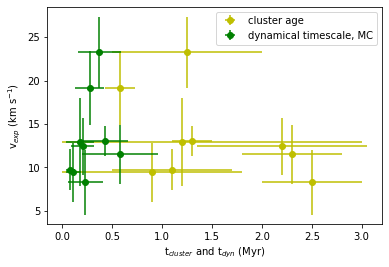

In [8]:
plt.errorbar(clusterAgeList,vExpList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList_MC,vExpList,xerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='g',label='dynamical timescale, MC')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

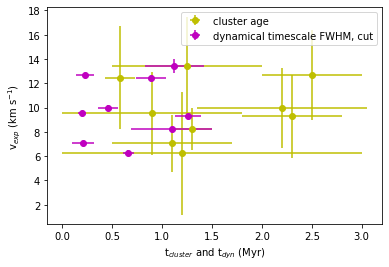

In [9]:
plt.errorbar(clusterAgeList,vExpListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(altDynAgeListFWHM,vExpListFWHM,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax], yerr=[vExpErrListFWHMMin,vExpErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

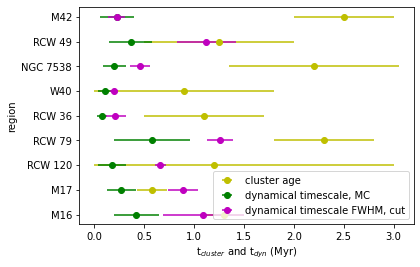

In [10]:
plt.errorbar(clusterAgeList,regionNames,xerr=[clusterAgeListMin,clusterAgeListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList_MC,regionNames,xerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC],fmt='o',color='g',label='dynamical timescale, MC')
plt.errorbar(altDynAgeListFWHM,regionNames,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('region')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_3.pdf',dpi=300)
plt.show()

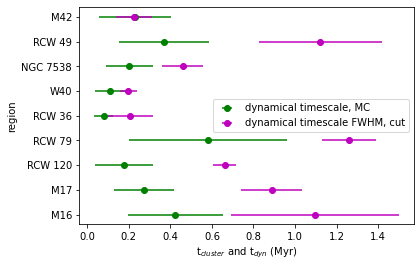

In [11]:
plt.errorbar(dynAgeList_MC,regionNames,xerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC],fmt='o',color='g',label='dynamical timescale, MC')
plt.errorbar(altDynAgeListFWHM,regionNames,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('region')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_3.pdf',dpi=300)
plt.show()

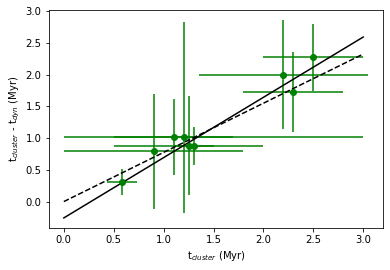

In [12]:
plt.errorbar(clusterAgeList,ageDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListMin,ageDiffListMax], fmt='o',color='g')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(x1,y1,'k-')
plt.plot(x1_no,y1_no,'k--')

#plt.legend()
#plt.savefig('test_1.pdf',dpi=300)
plt.show()

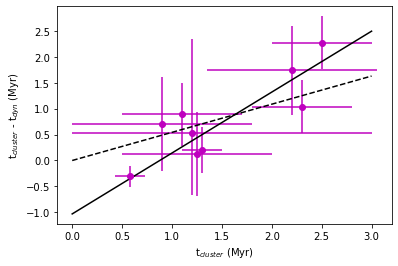

In [13]:
plt.errorbar(clusterAgeList,altAgeDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListFWHMMin,altAgeDiffListFWHMMax], fmt='o',color='m')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(xFWHMa,yFWHMa,'k-')
plt.plot(xFWHMa_no,yFWHMa_no,'k--')

#plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

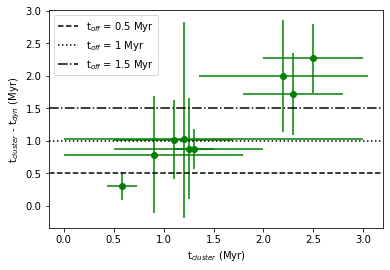

In [14]:
plt.errorbar(clusterAgeList,ageDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListMin,ageDiffListMax], fmt='o',color='g')

plt.axhline(y=0.5,color='k',linestyle = '--',label='t$_{off}$ = 0.5 Myr')
plt.axhline(y=1.,color='k',linestyle = ':',label='t$_{off}$ = 1 Myr')
plt.axhline(y=1.5,color='k',linestyle = '-.',label='t$_{off}$ = 1.5 Myr')

plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.legend(loc=2)
#plt.savefig('test.pdf',dpi=300)
plt.show()

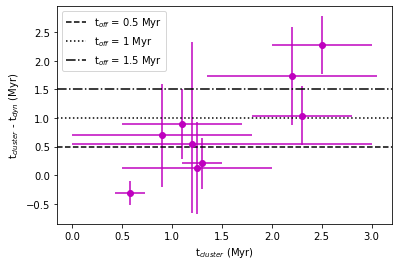

In [15]:
plt.errorbar(clusterAgeList,altAgeDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListFWHMMin,altAgeDiffListFWHMMax], fmt='o',color='m')

plt.axhline(y=0.5,color='k',linestyle = '--',label='t$_{off}$ = 0.5 Myr')
plt.axhline(y=1.,color='k',linestyle = ':',label='t$_{off}$ = 1 Myr')
plt.axhline(y=1.5,color='k',linestyle = '-.',label='t$_{off}$ = 1.5 Myr')

plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.legend(loc=2)
#plt.savefig('test.pdf',dpi=300)
plt.show()

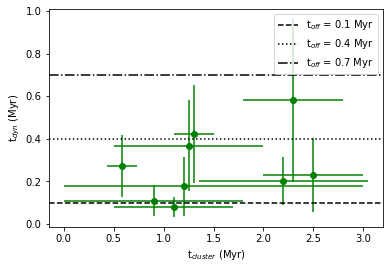

In [16]:
plt.errorbar(clusterAgeList,dynAgeList_MC,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC], fmt='o',color='g')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='t$_{off}$ = 0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='t$_{off}$ = 0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='t$_{off}$ = 0.7 Myr')

plt.legend()

#plt.savefig('test_2.pdf',dpi=300)
plt.show()

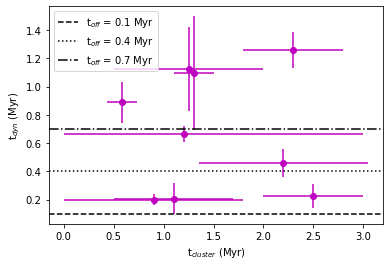

In [17]:
plt.errorbar(clusterAgeList,altDynAgeListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax], fmt='o',color='m')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='t$_{off}$ = 0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='t$_{off}$ = 0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='t$_{off}$ = 0.7 Myr')

plt.legend()

#plt.savefig('test_2.pdf',dpi=300)
plt.show()

In [18]:
## calculate chance all clusters are younger than 0.6 Myr or 1 Myr
## assuming the typical age of a cluster can range anywhere between 0 and 2.5 Myr

## 1 Myr
odds = 0.4**len(names) ## 1 Myr/2.5 Myr
print(odds)  ## > 3 sigma

odds = (0.6/2.5)**len(names)
print(odds)  ## > 4 sigma

0.0002621440000000001
2.6418075402239992e-06
